# Analising NiSi XRD data

In [1]:
import sys
print(sys.executable)

c:\Users\lhager\AppData\Local\Programs\Python\Python311\xrd_env\Scripts\python.exe


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import scipy.signal as signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

import plotly.graph_objects as go

from mp_api.client import MPRester
from pymatgen.analysis.diffraction.xrd import XRDCalculator
API_KEY = "Nc1dTFzE1dg6gchvs0voTKE07XuuXIKW"


plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True,                    # render text via LaTeX
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}"
})

### read file

In [3]:
file_path = r"../Data/XRD/02182026_Ni2Si_900grad_.xy"

data = pd.read_csv(file_path, delimiter=" ", skiprows=1, header=None, names=['Angle', 'Intensity'])

filename = os.path.basename(file_path)
name = filename.split("_", 1)[1].split("grad")[0]
print(name)

print(data.info())

Ni2Si_900
<class 'pandas.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Angle      3001 non-null   float64
 1   Intensity  3001 non-null   float64
dtypes: float64(2)
memory usage: 47.0 KB
None


### plot basic spectra starting point

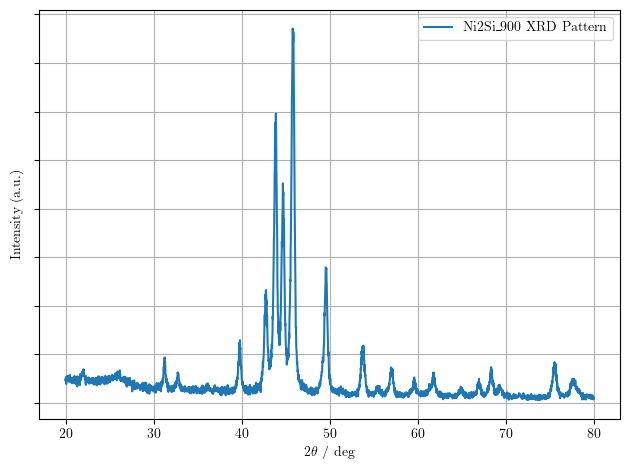

In [4]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['Intensity'], label=f'{name} XRD Pattern')

ax.axes.get_yaxis().set_ticklabels([])
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

## data processing
- remove background
- apply filter (Savitzky–Golay)
- normalise
- peak finding

In [5]:
# asymmetric least squares baseline correction
def baseline_als(y, lam=1e5, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2), dtype=None)
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w,0,L,L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

### baseline correction

In [6]:
baseline = baseline_als(data['Intensity'].values)
data['Intensity_corr'] = data['Intensity'] - baseline

C:\Users\lhager\AppData\Local\Temp\ipykernel_392\4060365311.py:9: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w*y)


### filter

In [7]:
data['filtered'] = signal.savgol_filter(data['Intensity_corr'], window_length=11, polyorder=3)

In [8]:
# fig, ax = plt.subplots()

# ax.plot(data['Angle'], data['filtered'], label=f'{name} XRD Pattern')

# ax.axes.get_yaxis().set_ticklabels([])
# plt.xlim(20, 80)
# plt.gca().set_ylim(bottom=0)
# plt.xlabel("$2\\theta$ / deg")
# plt.ylabel("Intensity (a.u.)")
# plt.legend()
# plt.tight_layout()
# plt.grid(True)
# # plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
# plt.show()

### normalise 

In [9]:
data['intensity_norm'] = data['filtered'] / data['filtered'].max()

### find peak position and height

In [34]:
# find peaks using scipy.signal.find_peaks
peaks, properties = signal.find_peaks(data['intensity_norm'], height=0.04, distance=5)
print("Peaks found at angles:", data['Angle'].iloc[peaks].values)

Peaks found at angles: [31.28 32.78 39.78 42.76 43.88 44.7  45.84 49.6  53.8  57.04 59.62 61.78
 68.4  75.54 75.8  77.56 77.78]


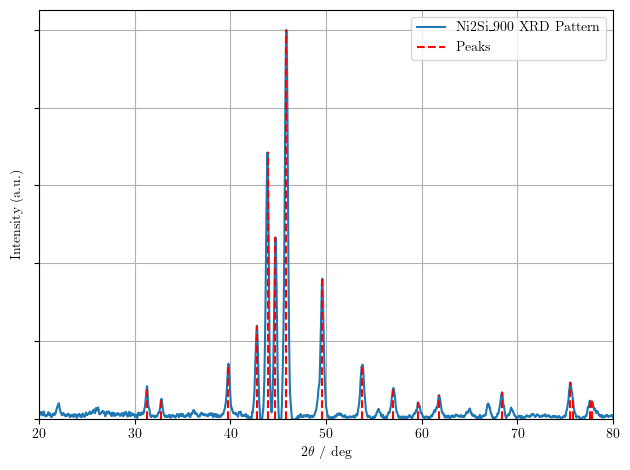

In [35]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['intensity_norm'], label=f'{name} XRD Pattern')

plt.vlines(data['Angle'].iloc[peaks].values, ymin=0, ymax=data['intensity_norm'].iloc[peaks], color='red', linestyle='--', label='Peaks')
ax.axes.get_yaxis().set_ticklabels([])
plt.xlim(20, 80)
plt.gca().set_ylim(bottom=0)
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

# expermamenting with auto labeling

In [ ]:
# def get_reference_peaks(material_id,
#     api_key,
#     wavelength="CuKa1",
#     intensity_threshold=5,
#     merge_tolerance=0.15
# ):
    
#     with MPRester(api_key) as mpr:
#         doc = mpr.materials.summary.search(
#             material_ids=[material_id],
#             fields=["material_id", "structure"]
#         )[0]

#     if not doc:
#         raise ValueError(f"No material found for material_id {material_id}")

#     structure = doc.structure
        
#     # Calculate pattern
#     calculator = XRDCalculator(wavelength=wavelength)
#     pattern = calculator.get_pattern(structure)

#     x = np.array(pattern.x)
#     y = np.array(pattern.y)
#     hkls = pattern.hkls

#     # Merge peaks
#     merged_x = []
#     merged_y = []
#     merged_hkl = []

#     current_x = x[0]
#     current_y = y[0]
#     current_hkl = hkls[0]

#     for i in range(1, len(x)):

#         if abs(x[i] - current_x) < merge_tolerance:

#             current_y += y[i]

#             # merge hkl lists
#             current_hkl = current_hkl + hkls[i]

#         else:

#             merged_x.append(current_x)
#             merged_y.append(current_y)
#             merged_hkl.append(current_hkl)

#             current_x = x[i]
#             current_y = y[i]
#             current_hkl = hkls[i]

#     merged_x.append(current_x)
#     merged_y.append(current_y)
#     merged_hkl.append(current_hkl)

#     merged_x = np.array(merged_x)
#     merged_y = np.array(merged_y)

#     # Normalize intensity
#     merged_y = 100 * merged_y / np.max(merged_y)

#     # Filter weak peaks
#     mask = merged_y >= intensity_threshold

#     merged_x = merged_x[mask]
#     merged_y = merged_y[mask]
#     merged_hkl = [merged_hkl[i] for i in range(len(mask)) if mask[i]]

#     # Create clean labels
#     labels = []

#     for hkl_group in merged_hkl:

#         unique = set(tuple(h["hkl"]) for h in hkl_group)

#         label = ",".join(str(hkl) for hkl in sorted(unique))

#         labels.append(label)

#     return {
#         "two_theta": merged_x,
#         "intensity": merged_y,
#         "hkl": labels
#     }

In [24]:
def get_clean_reference(material_id, api_key, wavelength="CuKa1", intensity_threshold=5):
    with MPRester(api_key) as mpr:
        docs = mpr.materials.summary.search(material_ids=[material_id], fields=["structure"])
        if not docs:
            raise ValueError(f"No material found for {material_id}")
        structure = docs[0].structure

    calculator = XRDCalculator(wavelength=wavelength)
    pattern = calculator.get_pattern(structure)
    
    # pattern.x and pattern.y are already sorted by 2-theta
    x, y = np.array(pattern.x), np.array(pattern.y)
    
    # Normalize to 100
    y = 100 * y / np.max(y)
    
    # Filter by threshold first to remove noise/ghost peaks
    mask = y >= intensity_threshold
    return {"two_theta": x[mask], "intensity": y[mask]}

In [ ]:
reference_phases = [
    {"phase": "NiSi2", "id": "mp-2291", "peaks": get_clean_reference("mp-2291", API_KEY)['two_theta']},
    {"phase": "NiSi", "id": "mp-1095177", "peaks": get_clean_reference("mp-1095177", API_KEY)['two_theta']},
    {"phase": "NiSi", "id": "mp-351", "peaks": get_clean_reference("mp-351", API_KEY)['two_theta']},
    {"phase": "Ni2Si", "id": "mp-1118", "peaks": get_clean_reference("mp-1118", API_KEY)['two_theta']},
    {"phase": "Ni2Si", "id": "mp-507", "peaks": get_clean_reference("mp-507", API_KEY)['two_theta']},
    {"phase": "Ni", "id": "mp-23", "peaks": get_clean_reference("mp-23", API_KEY)['two_theta']},
    {"phase": "Ni", "id": "mp-10257", "peaks": get_clean_reference("mp-10257", API_KEY)['two_theta']},
    {"phase": "Ni31Si12", "id": "mp-27276", "peaks": get_clean_reference("mp-27276", API_KEY)['two_theta']},
    {"phase": "Ni3Si2", "id": "mp-29667", "peaks": get_clean_reference("mp-29667", API_KEY)['two_theta']},
]

In [41]:
phase_targets = {
    "NiSi2 (Cubic)": "mp-2291",
    "NiSi (Cubic)":  "mp-1095177",
    "NiSi (Ortho)":  "mp-351",
    "Ni2Si (Ortho)": "mp-1118",
    "Ni2Si (Hex)": "mp-507",
    "Ni (Cubic)":    "mp-23",
    "Ni (Hex)":    "mp-10257",
    "Ni3Si2 (Ortho)": "mp-29667",
    "Ni31Si12 (Trigo)": "mp-27276"
}

# Fetch all reference data once
all_references = {}
for name, m_id in phase_targets.items():
    print(f"Fetching {name}...")
    all_references[name] = get_clean_reference(m_id, API_KEY)

Fetching NiSi2 (Cubic)...


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Fetching NiSi (Cubic)...


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Fetching NiSi (Ortho)...


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Fetching Ni2Si (Ortho)...


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Fetching Ni2Si (Hex)...


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Fetching Ni (Cubic)...


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Fetching Ni (Hex)...


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Fetching Ni3Si2 (Ortho)...


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Fetching Ni31Si12 (Trigo)...


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [ ]:
fig = go.Figure()

# 1. Plot the Experimental Data (the black line)
fig.add_trace(go.Scatter(
    x=data['Angle'], 
    y=data['intensity_norm'],
    mode='lines',
    name='Experimental Data',
    line=dict(color='black', width=1.5)
))

# 2. Add Reference Markers
# We use different colors/symbols for each phase fetched from the API
symbols = ['circle', 'square', 'triangle-up', 'diamond', 'star']

for i, (name, ref) in enumerate(all_references.items()):
    # We plot these at a fixed height or relative to your data
    # Here, we plot them at y=1.05 (just above the normalized data)
    fig.add_trace(go.Scatter(
        x=ref['two_theta'],
        y=[1.05] * len(ref['two_theta']), # Align them in a row at the top
        mode='markers',
        name=name,
        marker=dict(symbol=symbols[i % len(symbols)], size=10),
        hovertemplate=f"<b>{name}</b><br>2θ: %{{x}}<br>Ref Intensity: %{{text}}%<extra></extra>",
        text=ref['intensity'] # Store relative intensity in hover text
    ))

# 3. Scientific Styling
fig.update_layout(
    title="Phase Identification: Nickel Silicides",
    xaxis_title="2θ (degrees)",
    yaxis_title="Intensity (Normalized)",
    template="plotly_white",
    hovermode="x unified",
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
)

fig.show()

In [25]:
reference_phases = [
    {"phase": "NiSi2", "id": "mp-2291", "peaks": get_clean_reference("mp-2291", API_KEY)['two_theta']},
    {"phase": "NiSi", "id": "mp-1095177", "peaks": get_clean_reference("mp-1095177", API_KEY)['two_theta']},
    {"phase": "NiSi", "id": "mp-351", "peaks": get_clean_reference("mp-351", API_KEY)['two_theta']},
    {"phase": "Ni2Si", "id": "mp-1118", "peaks": get_clean_reference("mp-1118", API_KEY)['two_theta']},
    {"phase": "Ni2Si", "id": "mp-507", "peaks": get_clean_reference("mp-507", API_KEY)['two_theta']},
    {"phase": "Ni", "id": "mp-23", "peaks": get_clean_reference("mp-23", API_KEY)['two_theta']},
    {"phase": "Ni", "id": "mp-10257", "peaks": get_clean_reference("mp-10257", API_KEY)['two_theta']},
    {"phase": "Ni31Si12", "id": "mp-27276", "peaks": get_clean_reference("mp-27276", API_KEY)['two_theta']},
    {"phase": "Ni3Si2", "id": "mp-29667", "peaks": get_clean_reference("mp-29667", API_KEY)['two_theta']},
]

Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


|Phase|material_id|shape|  |   |   |   |   |   |  |  |  |  |  |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|$NiSi_2$|mp-2291   | Cubic | 28.68  |  47.72 | 56.63  | 69.78  | 77.12 |  |  |  |  |  |  |
|$NiSi$|mp-1095177  | Cubic | 27.77  |  34.46 | 40.00  | 44.97  | 49.54 | 61.74 | 65.48 | 69.12 | 76.15 | 79.58 |  |
|$NiSi$|mp-351      | Ortho | 31.33 | 34.87 | 35.97 | 44.53 | 46.01 | 47.57 | 52.35 | 56 | 76.29 | 79.6 |  |
|$Ni_2Si$|mp-1118   | Ortho | 27.25 | 32.85 | 39.87 | 42.83 | 44.12 | 45.94 | 49.25 | 54.07 | 68.86 | 76.14 | 78.78 |
|$Ni_2Si$|mp-507    | hex   | 32.28 | 45.72 | 46.88 | 67.57 | 77.62 |  |  |  |  |  |  |
|$Ni$   |mp-23      | Cubic | 45.15 | 52.63 | 77.65 |  |  |  |  |  |  |  |  |
|$Ni$   |mp-10257   | hex   | 42.61 | 44.45 | 48.36 | 63.27 | 77.99 |  |  |  |  |  |  |

In [38]:
# Your experimental peaks found via find_peaks
exp_peaks = data['Angle'].iloc[peaks].values 

tolerance = 0.2  # Degrees 2-theta
results = {}

for ref in reference_phases:
    matched_angles = []
    for p_ref in ref['peaks']:
        # Find if any experimental peak is within the tolerance of the reference peak
        diff = np.abs(exp_peaks - p_ref)
        if np.any(diff <= tolerance):
            # Get the actual experimental angle that matched
            best_match = exp_peaks[np.argmin(diff)]
            matched_angles.append(best_match)
    
    results[f"{ref['phase']}_{ref['id']}"] = matched_angles

fig = go.Figure()

# Plot the raw data
fig.add_trace(go.Scatter(x=data['Angle'], y=data['intensity_norm'], name='Data', line=dict(color='black')))

# Define marker styles
styles = {'NiSi2': 'circle', 'NiSi': 'square', 'Ni2Si': 'triangle-up', 'Ni': 'star'}

for label, matched_peaks in results.items():
    if not matched_peaks: continue
    
    phase_name = label.split('_')[0]
    
    # Filter intensities for these specific matched peaks
    # We find the index in the original 'data' where the angle matches our matched_peaks
    y_vals = data.set_index('Angle').loc[matched_peaks]['intensity_norm']
    
    fig.add_trace(go.Scatter(
        x=matched_peaks,
        y=y_vals + 0.05, # Offset for visibility
        mode='markers',
        marker=dict(symbol=styles.get(phase_name, 'cross'), size=10),
        name=label
    ))

fig.update_layout(
    xaxis_title="2θ (degrees)",
    yaxis_title="Intensity (a.u.)",
    template="plotly_white",
    hovermode="x unified"
)

# fig.write_html(f'../Images/XRD/{name}.html')
fig.show()

{'Ni3Si2', 'Ni31Si12', 'NiSi', 'Ni2Si', 'Ni'}


C:\Users\lhager\AppData\Local\Temp\ipykernel_392\3609865885.py:37: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



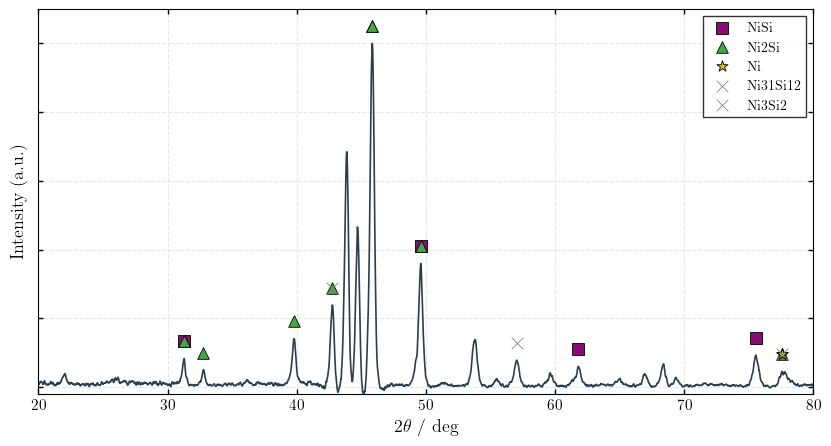

In [37]:
marker_map = {
    'NiSi2': 'o',  # Circle
    'NiSi': 's',   # Square
    'Ni2Si': '^',  # Triangle
    'Ni': '*'      # Star
}
color_map = {
    'NiSi2': '#00006a', 
    'NiSi': '#8b0a74',  #8b0a74  7f007b
    'Ni2Si': '#43a743', 
    'Ni': '#d8c409'
}

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(data['Angle'], data['intensity_norm'], color='#2c3e50', lw=1.2, zorder=2)

plotted_phases = set()
for label, matched_peaks in results.items():
    if not matched_peaks: 
        continue

    phase_name = label.split('_')[0]

    y_vals = []
    for angle in matched_peaks:
        # Find the intensity at the closest angle in your dataframe
        idx = (data['Angle'] - angle).abs().idxmin()
        y_vals.append(data.loc[idx, 'intensity_norm'])

    y_vals = np.array(y_vals)
    
    # Check if we should add this to the legend
    current_label = phase_name if phase_name not in plotted_phases else "_" + phase_name
    plotted_phases.add(phase_name)

    ax.scatter(matched_peaks, y_vals + 0.05, 
               marker=marker_map.get(phase_name, 'x'),
               color=color_map.get(phase_name, 'gray'),
               label=current_label if not current_label.startswith('_') else None,
               s=70, edgecolor='black', linewidth=0.6, zorder=5)

print(plotted_phases)


ax.tick_params(axis='both', which='both', direction='in', 
               top=True, right=True, 
               width=1.0, labelsize=11)

ax.set_yticklabels([])
ax.set_xlim(20, 80)
ax.set_ylim(-0.02, 1.1)

ax.set_xlabel(r"$2\theta$ / deg", fontsize=13)
ax.set_ylabel(r"Intensity (a.u.)", fontsize=13)

ax.grid(True, linestyle='--', alpha=0.3, zorder=1)
ax.legend(frameon=True, edgecolor='black', fancybox=False, fontsize=10, loc='upper right')

# plt.savefig(f'../Images/XRD/{name}.pdf', dpi=500)
plt.show()
